In [54]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import preprocessing
import string
from scipy.stats import boxcox

In [2]:
xl = pd.ExcelFile('2017-Spring-Match-Data-OraclesElixir-2017-03-13.xlsx')

In [4]:
xl.sheet_names

[u'Sheet1']

In [5]:
df = xl.parse('Sheet1')

In [7]:
df.head()

,gameid,url,league,split,date,week,game,patchno,playerid,side,...,csdat10,goldat10,oppgoldat10,gdat10,goldat15,oppgoldat15,gdat15,xpat10,oppxpat10,xpdat10
0,30267,http://matchhistory.na.leagueoflegends.com/en/...,LCK,2017-1,42752.090544,1.1,1,7.01,1,Blue,...,-1.0,3156.0,3139.0,17.0,4762.0,4900.0,-138.0,4509.0,4744.0,-235.0
1,30267,http://matchhistory.na.leagueoflegends.com/en/...,LCK,2017-1,42752.090544,1.1,1,7.01,2,Blue,...,8.0,2708.0,2800.0,-92.0,4359.0,4291.0,68.0,3001.0,2889.0,112.0
2,30267,http://matchhistory.na.leagueoflegends.com/en/...,LCK,2017-1,42752.090544,1.1,1,7.01,3,Blue,...,2.0,3460.0,3439.0,21.0,5359.0,5199.0,160.0,4818.0,5160.0,-342.0
3,30267,http://matchhistory.na.leagueoflegends.com/en/...,LCK,2017-1,42752.090544,1.1,1,7.01,4,Blue,...,-7.0,3005.0,3199.0,-194.0,4747.0,4879.0,-132.0,2895.0,3080.0,-185.0
4,30267,http://matchhistory.na.leagueoflegends.com/en/...,LCK,2017-1,42752.090544,1.1,1,7.01,5,Blue,...,2.0,2001.0,2182.0,-181.0,3306.0,3228.0,78.0,2681.0,2459.0,222.0


In [8]:
df.columns

Index([u'gameid', u'url', u'league', u'split', u'date', u'week', u'game',
       u'patchno', u'playerid', u'side', u'position', u'player', u'team',
       u'champion', u'ban1', u'ban2', u'ban3', u'ban4', u'ban5', u'gamelength',
       u'result', u'k', u'd', u'a', u'teamkills', u'teamdeaths', u'doubles',
       u'triples', u'quadras', u'pentas', u'fb', u'fbvictim', u'fbtime',
       u'kpm', u'okpm', u'ckpm', u'fd', u'fdtime', u'teamdragkills',
       u'oppdragkills', u'elementals', u'oppelementals', u'firedrakes',
       u'waterdrakes', u'earthdrakes', u'airdrakes', u'elders', u'oppelders',
       u'herald', u'heraldtime', u'ft', u'fttime', u'firstmidouter',
       u'firsttothreetowers', u'teamtowerkills', u'opptowerkills', u'fbaron',
       u'fbarontime', u'teambaronkills', u'oppbaronkills', u'dmgtochamps',
       u'dmgtochampsperminute', u'dmgshare', u'earnedgoldshare', u'wards',
       u'wpm', u'wardshare', u'wardkills', u'wcpm', u'visionwards',
       u'visionwardbuys', u'visiblewar

In [24]:
#Columns that are likely to be noise are dropped
feat_cols = ['league', 'patchno', 'side', 'position', 'player', 'team', 'champion',
            'gamelength', 'result', 'k', 'd', 'a', 'fb', 'fbvictim', 'fbtime', 'kpm', 'okpm', 'teamdragkills',
            'oppdragkills', 'ft', 'fttime', 'firstmidouter', 'firsttothreetowers', 'teamtowerkills',
            'fbaron', 'fbarontime', 'teambaronkills', 'oppbaronkills', 'dmgtochampsperminute', 'dmgshare', 'earnedgoldshare',
            'wards', 'wpm', 'visionwardbuys', 'earnedgpm', 'cspm']
df_cleaned = df[feat_cols]

In [25]:
df_cleaned.head()

,league,patchno,side,position,player,team,champion,gamelength,result,k,...,teambaronkills,oppbaronkills,dmgtochampsperminute,dmgshare,earnedgoldshare,wards,wpm,visionwardbuys,earnedgpm,cspm
0,LCK,7.01,Blue,Top,Lindarang,ROX Tigers,Poppy,46.466667,0,1,...,0.0,2.0,388.149211,0.191836,0.193360,31.0,0.667145,8.0,205.938594,7.812052
1,LCK,7.01,Blue,Jungle,Seonghwan,ROX Tigers,Graves,46.466667,0,1,...,0.0,2.0,365.143472,0.180465,0.174730,43.0,0.925395,15.0,186.096413,5.423242
2,LCK,7.01,Blue,Middle,Mickey,ROX Tigers,Syndra,46.466667,0,5,...,0.0,2.0,548.672884,0.271171,0.266871,26.0,0.559541,4.0,284.231277,10.308465
3,LCK,7.01,Blue,ADC,Sangyoon,ROX Tigers,Ashe,46.466667,0,4,...,0.0,2.0,312.783357,0.154587,0.242361,14.0,0.301291,3.0,258.126542,8.823529
4,LCK,7.01,Blue,Support,Key,ROX Tigers,Malzahar,46.466667,0,2,...,0.0,2.0,408.593974,0.201940,0.122678,85.0,1.829268,27.0,130.658824,1.011478


In [68]:
df_nalcs = df_cleaned.loc[df_cleaned.league == 'NALCS']

In [69]:
df_nalcs.dtypes

league                   object
patchno                 float64
side                     object
position                 object
player                   object
team                     object
champion                 object
gamelength              float64
result                    int64
k                         int64
d                         int64
a                         int64
fb                      float64
fbvictim                float64
fbtime                  float64
kpm                     float64
okpm                    float64
teamdragkills             int64
oppdragkills              int64
ft                      float64
fttime                  float64
firstmidouter           float64
firsttothreetowers      float64
teamtowerkills            int64
fbaron                  float64
fbarontime              float64
teambaronkills          float64
oppbaronkills           float64
dmgtochampsperminute    float64
dmgshare                float64
earnedgoldshare         float64
wards   

In [70]:
df_nalcs.describe()

,patchno,gamelength,result,k,d,a,fb,fbvictim,fbtime,kpm,...,teambaronkills,oppbaronkills,dmgtochampsperminute,dmgshare,earnedgoldshare,wards,wpm,visionwardbuys,earnedgpm,cspm
count,2076.000000,2076.000000,2076.00000,2076.000000,2076.000000,2076.000000,2076.000000,2076.000000,2076.000000,2076.000000,...,2076.000000,2076.000000,2076.000000,1730.000000,1730.000000,2076.000000,2076.000000,2076.000000,2076.000000,2076.000000
mean,7.024393,37.339017,0.50000,4.556840,4.563584,10.287091,0.166667,0.166667,5.212160,0.123658,...,0.794798,0.794798,653.490270,0.200000,0.200000,42.307322,1.127483,11.186898,379.346174,10.263798
std,0.011942,7.661787,0.50012,5.357858,5.152359,11.919871,0.372768,0.372768,2.849021,0.146703,...,0.809160,0.809160,640.234024,0.086174,0.047839,43.030535,1.085219,11.572828,351.998462,9.652221
min,7.010000,24.116667,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,27.976879,0.017497,0.073223,5.000000,0.143003,0.000000,65.647679,0.210158
25%,7.010000,31.500000,0.00000,1.000000,2.000000,3.000000,0.000000,0.000000,3.000000,0.029155,...,0.000000,0.000000,272.771213,NaN,NaN,15.000000,0.433526,4.000000,196.119189,5.001764
50%,7.020000,36.600000,0.50000,3.000000,3.000000,7.000000,0.000000,0.000000,4.285067,0.075527,...,1.000000,1.000000,424.887659,NaN,NaN,22.000000,0.567700,6.000000,247.985703,7.864132
75%,7.040000,42.066667,1.00000,6.000000,5.000000,11.000000,0.000000,0.000000,6.966250,0.156369,...,1.000000,1.000000,652.962274,NaN,NaN,50.000000,1.357213,13.000000,307.100617,9.342395
max,7.040000,58.283333,1.00000,34.000000,34.000000,73.000000,1.000000,1.000000,15.000000,1.093319,...,5.000000,5.000000,3780.566200,0.655369,0.315946,239.000000,4.291254,68.000000,1539.556420,36.851335


In [71]:
#there are lots of NaN's because the team is also included as player.  
#We'll drop na's as a whole to see if our dataset shrinks significantly
df_nalcs_dropna = df_nalcs.dropna()

In [72]:
df_nalcs_dropna.describe()

,patchno,gamelength,result,k,d,a,fb,fbvictim,fbtime,kpm,...,teambaronkills,oppbaronkills,dmgtochampsperminute,dmgshare,earnedgoldshare,wards,wpm,visionwardbuys,earnedgpm,cspm
count,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.00000,1660.00000,1660.000000,1660.000000,...,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000
mean,7.024458,37.578313,0.500000,2.736145,2.740361,6.187349,0.10000,0.10000,5.145724,0.073723,...,0.828313,0.828313,392.499380,0.200000,0.200000,25.583735,0.677463,6.752410,228.044085,6.167085
std,0.011902,7.647468,0.500151,2.452002,1.827243,3.967373,0.30009,0.30009,2.851241,0.067074,...,0.809106,0.809106,195.949788,0.086383,0.047709,17.317887,0.406016,4.914657,64.337168,3.098730
min,7.010000,24.116667,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.000000,0.000000,27.976879,0.017497,0.073223,5.000000,0.143003,0.000000,65.647679,0.210158
25%,7.010000,31.766667,0.000000,1.000000,1.000000,3.000000,0.00000,0.00000,3.000000,0.025181,...,0.000000,0.000000,248.210297,0.136248,0.180844,14.000000,0.410327,3.000000,184.133362,4.532512
50%,7.020000,36.808333,0.500000,2.000000,3.000000,6.000000,0.00000,0.00000,4.096858,0.058196,...,1.000000,1.000000,368.431645,0.197921,0.210021,19.000000,0.516584,5.000000,231.885814,7.228862
75%,7.040000,42.166667,1.000000,4.000000,4.000000,9.000000,0.00000,0.00000,6.000000,0.109165,...,1.000000,1.000000,511.549276,0.255877,0.233361,30.000000,0.825539,9.000000,275.289974,8.535052
max,7.040000,58.283333,1.000000,14.000000,9.000000,23.000000,1.00000,1.00000,15.000000,0.379147,...,5.000000,5.000000,1333.791411,0.655369,0.315946,130.000000,2.290749,37.000000,405.298522,12.095376


In [73]:
#transforming categoricals.  IMPORTANT: IF INCLUDING NEW DATA, YOU MUST ENCODE EVERYTHING AT ONCE OR YOU WILL HAVE MISMATCHED LABELS
categoricals = [x for x in df_nalcs.columns if df_nalcs[x].dtype == 'object']

for feat in categoricals:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df_nalcs_dropna[feat].values))
    df_nalcs_dropna[feat] = lbl.transform(list(df_nalcs_dropna[feat].values))

C:\Users\Drace\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [74]:
df_nalcs_dropna.describe()

,league,patchno,side,position,player,team,champion,gamelength,result,k,...,teambaronkills,oppbaronkills,dmgtochampsperminute,dmgshare,earnedgoldshare,wards,wpm,visionwardbuys,earnedgpm,cspm
count,1660.0,1660.000000,1660.000000,1660.00000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,...,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000
mean,0.0,7.024458,0.500000,2.00000,27.420482,4.557229,38.736145,37.578313,0.500000,2.736145,...,0.828313,0.828313,392.499380,0.200000,0.200000,25.583735,0.677463,6.752410,228.044085,6.167085
std,0.0,0.011902,0.500151,1.41464,15.979879,2.899727,20.702497,7.647468,0.500151,2.452002,...,0.809106,0.809106,195.949788,0.086383,0.047709,17.317887,0.406016,4.914657,64.337168,3.098730
min,0.0,7.010000,0.000000,0.00000,0.000000,0.000000,0.000000,24.116667,0.000000,0.000000,...,0.000000,0.000000,27.976879,0.017497,0.073223,5.000000,0.143003,0.000000,65.647679,0.210158
25%,0.0,7.010000,0.000000,1.00000,13.000000,2.000000,23.000000,31.766667,0.000000,1.000000,...,0.000000,0.000000,248.210297,0.136248,0.180844,14.000000,0.410327,3.000000,184.133362,4.532512
50%,0.0,7.020000,0.500000,2.00000,27.000000,5.000000,40.000000,36.808333,0.500000,2.000000,...,1.000000,1.000000,368.431645,0.197921,0.210021,19.000000,0.516584,5.000000,231.885814,7.228862
75%,0.0,7.040000,1.000000,3.00000,41.000000,7.000000,53.000000,42.166667,1.000000,4.000000,...,1.000000,1.000000,511.549276,0.255877,0.233361,30.000000,0.825539,9.000000,275.289974,8.535052
max,0.0,7.040000,1.000000,4.00000,55.000000,9.000000,80.000000,58.283333,1.000000,14.000000,...,5.000000,5.000000,1333.791411,0.655369,0.315946,130.000000,2.290749,37.000000,405.298522,12.095376


In [76]:
#factorize the patches
df_nalcs_dropna.patchno = pd.Categorical(df_nalcs_dropna.patchno)

C:\Users\Drace\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [77]:
#Basic EDA tools
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()
%matplotlib inline

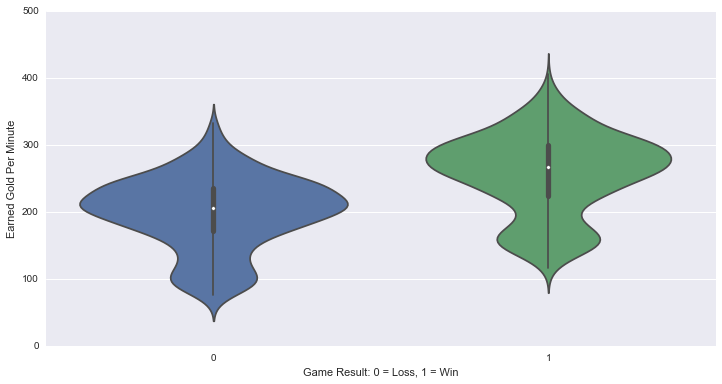

In [37]:
#Examine the distribution of goldpermin by wins and losses
plt.figure(figsize=(12,6))
sns.violinplot(x = 'result', y = 'earnedgpm', data=df_nalcs_dropna)
plt.xlabel('Game Result: 0 = Loss, 1 = Win')
plt.ylabel('Earned Gold Per Minute')
plt.show()

We see, unsurprisingly, those who win tend to earn more gold per minute, roughly about 50-100 more.  Keep in mind, there tends to be large swings of gold towards the end of the game so this metric isn't smooth.

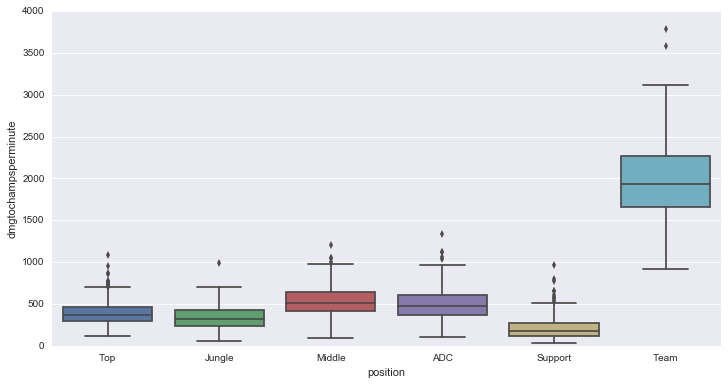

In [47]:
plt.figure(figsize=(12,6))
sns.boxplot(x = 'position', y = 'dmgtochampsperminute', data = df_nalcs)

We can examine the damage to champions by minute from positional perspective.  From this we can see, positions play a big difference so it'll be interesting to examine whether there is correlation between gold earned per minute and damage done to champions per minute.

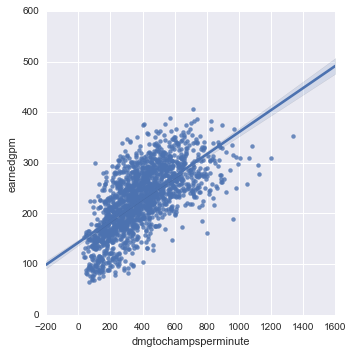

In [43]:
sns.lmplot(x='dmgtochampsperminute', y = 'earnedgpm', data=df_nalcs_dropna)

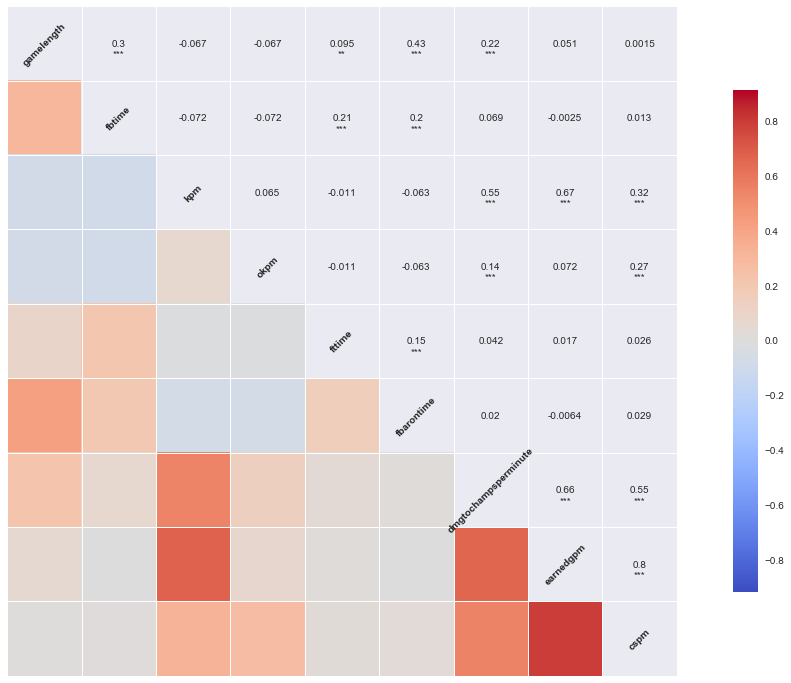

In [50]:
#Let's examine some continuous variables and any correlations
continuous_feats = ['gamelength', 'fbtime', 'kpm', 'okpm', 'fttime', 'fbarontime', 'dmgtochampsperminute', 'earnedgpm', 'cspm']
plt.figure(figsize=(20,12))
sns.corrplot(df_nalcs_dropna[continuous_feats])

In [67]:
df_nalcs_dropna

(array([0, 0, 0, ..., 3, 3, 3]),
 Float64Index([7.01, 7.02, 7.03, 7.04], dtype='float64'))

In [84]:
#creating predictors and target
pred_cols = ['patchno', 'side', 'position', 'player', 'team', 'champion',
            'gamelength', 'k', 'd', 'a', 'fb', 'fbvictim', 'fbtime', 'kpm', 'okpm', 'teamdragkills',
            'oppdragkills', 'ft', 'fttime', 'firstmidouter', 'firsttothreetowers', 'teamtowerkills',
            'fbaron', 'fbarontime', 'teambaronkills', 'oppbaronkills', 'dmgtochampsperminute', 'dmgshare', 'earnedgoldshare',
            'wards', 'wpm', 'visionwardbuys', 'earnedgpm', 'cspm']
X = df_nalcs_dropna[pred_cols]
y = df_nalcs_dropna.result

In [85]:
#trying a default random forest with standard parameters.  Max depth is kept low to prevent overfitting due to nature of data
rf = RandomForestClassifier(n_estimators=500, max_depth=3)
print "Five fold cross validation accuracy: ", np.mean(cross_val_score(rf, X, y, cv=5))

Five fold cross validation accuracy:  0.924698795181


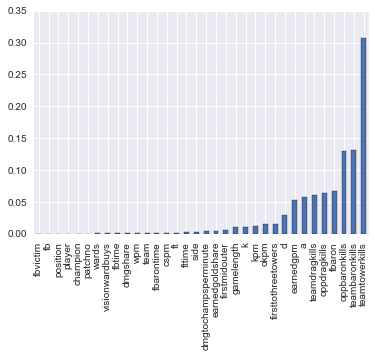

In [86]:
rf.fit(X, y)
pd.Series(index = pred_cols, data = rf.feature_importances_).sort_values().plot(kind = 'bar')

The model's accuracy score has certain issues similar to data leakage.  Teamtowerkills plays too large of a role in this prediction model simply because there are five turrets within a base which are generally removed before ending the game.  This plays a lopsided role in it's "prediction value" essentially predicting that if a team "wins", it will "win".  We'll remove it to see if we can create a model that is more informative.

Five fold cross validation accuracy:  0.885542168675


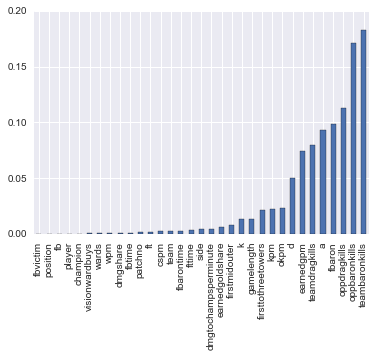

In [87]:
new_pred = pred_cols = ['patchno', 'side', 'position', 'player', 'team', 'champion',
            'gamelength', 'k', 'd', 'a', 'fb', 'fbvictim', 'fbtime', 'kpm', 'okpm', 'teamdragkills',
            'oppdragkills', 'ft', 'fttime', 'firstmidouter', 'firsttothreetowers', 'earnedgoldshare',
            'fbaron', 'fbarontime', 'teambaronkills', 'oppbaronkills', 'dmgtochampsperminute', 'dmgshare', 
            'wards', 'wpm', 'visionwardbuys', 'earnedgpm', 'cspm']
X = df_nalcs_dropna[new_pred]
rf = RandomForestClassifier(n_estimators=500, max_depth=3)
print "Five fold cross validation accuracy: ", np.mean(cross_val_score(rf, X, y, cv=5))
rf.fit(X, y)
pd.Series(index = new_pred, data = rf.feature_importances_).sort_values().plot(kind = 'bar')

Once again, at the moment, I'm wary of any features playing such a significant role.  A mistake made earlier during the EDA process was not checking whether certain features share a close to 1:1 correlation with our target.